## Introduction to PyTorch

> This notebook is a part of [AI for Beginners Curricula](http://github.com/microsoft/ai-for-beginners). Visit the repository for complete set of learning materials.

### Neural Frameworks

We have learnt that to train neural networks you need:
* Quickly multiply matrices (tensors)
* Compute gradients to perform gradient descent optimization

What neural network frameworks allow you to do:
* Operate with tensors on whatever compute is available, CPU or GPU, or even TPU
* Automatically compute gradients (they are explicitly programmed for all built-in tensor functions)

Optionally:
* Neural Network constructor / higher level API (describe network as a sequence of layers)
* Simple training functions (`fit`, as in Scikit Learn)
* A number of optimization algorithms in addition to gradient descent
* Data handling abstractions (that will ideally work on GPU, too)

### Most Popular Frameworks

* Tensorflow 1.x - first widely available framework (Google). Allowed to define static computation graph, push it to GPU, and explicitly evaluate it
* PyTorch - a framework from Facebook that is growing in popularity
* Keras - higher level API on top of Tensorflow/PyTorch to unify and simplify using neural networks (Francois Chollet)
* Tensorflow 2.x + Keras - new version of Tensorflow with integrated Keras functionality, which supports **dynamic computation graph**, allowing to perform tensor operations very similar to numpy (and PyTorch)

In this Notebook, we will learn to use PyTorch. You need to make sure that you have recent version of PyTorch installed - to do it, follow the [instructions on their site](https://pytorch.org/get-started/locally/). It is normally as simple as doing
```
pip install torch torchvision
```
or
```
conda install pytorch -c pytorch
```

In [1]:
import torch
torch.__version__

'1.8.2'

## Basic Concepts: Tensor

**Tensor** is a multi-dimensional array. It is very convenient to use tensors to represent different types of data:
* 400x400 - black-and-white picture
* 400x400x3 - color picture 
* 16x400x400x3 - minibatch of 16 color pictures
* 25x400x400x3 - one second of 25-fps video
* 8x25x400x400x3 - minibatch of 8 1-second videos

### Simple Tensors

You can easily create simple tensors from lists of np-arrays, or generate random ones:

In [2]:
a = torch.tensor([[1,2],[3,4]])
print(a)
a = torch.randn(size=(10,3))
print(a)

tensor([[1, 2],
        [3, 4]])
tensor([[ 1.3577,  0.7550, -1.7503],
        [-0.7006,  0.1918, -0.2571],
        [ 0.2964, -0.3188,  0.4575],
        [-0.1524,  1.3446,  0.7218],
        [-1.4642, -1.3296, -0.5098],
        [ 2.2282,  0.5065,  0.6176],
        [-0.3013,  0.9485,  0.1195],
        [ 1.0261,  1.5614, -0.1013],
        [-0.2211, -0.4294, -2.2319],
        [ 1.4257, -0.6976,  0.0656]])


You can use arithmetic operations on tensors, which are performed element-wise, as in numpy. Tensors are automatically expanded to required dimension, if needed. To extract numpy-array from tensor, use `.numpy()`:

In [3]:
print(a-a[0])
print(torch.exp(a)[0].numpy())

tensor([[ 0.0000,  0.0000,  0.0000],
        [-2.0583, -0.5631,  1.4932],
        [-1.0613, -1.0738,  2.2078],
        [-1.5101,  0.5896,  2.4722],
        [-2.8219, -2.0846,  1.2405],
        [ 0.8706, -0.2485,  2.3679],
        [-1.6590,  0.1935,  1.8698],
        [-0.3316,  0.8065,  1.6490],
        [-1.5788, -1.1844, -0.4816],
        [ 0.0680, -1.4526,  1.8159]])
[3.887189   2.1276016  0.17371987]


## In-place and out-of-place Operations

Tensor operations such as `+`/`add` return new tensors. However, sometimes you need to modify the existing tensor in-place. Most of the operations have their in-place counterparts, which end with `_`:

In [4]:
u = torch.tensor(5)
print("Result when adding out-of-place:",u.add(torch.tensor(3)))
u.add_(torch.tensor(3))
print("Result after adding in-place:", u)

Result when adding out-of-place: tensor(8)
Result after adding in-place: tensor(8)


This is how we can compute the sum or all rows in a matrix in a naive way:

In [5]:
s = torch.zeros_like(a[0])
for i in a:
  s.add_(i)

print(s)

tensor([ 3.4945,  2.5325, -2.8684])


But it is much better to use

In [6]:
torch.sum(a,axis=0)

tensor([ 3.4945,  2.5325, -2.8684])

You can read more on PyTorch tensors in the [official documentation](https://pytorch.org/tutorials/beginner/basics/tensorqs_tutorial.html)

## Computing Gradients

For back propagation, you need to compute gradients. We can set any PyTorch Tensor's attribute `requires_grad` to `True`, which will result in all operations with this tensor being tracked for gradient calculations. To compute the gradients, you need to call `backward()` method, after which the gradient will become available using `grad` attribute:


In [7]:
a = torch.randn(size=(2, 2), requires_grad=True)
b = torch.randn(size=(2, 2))

c = torch.mean(torch.sqrt(torch.square(a) + torch.square(b)))  # Do some math using `a`
c.backward() # call backward() to compute all gradients
# What's the gradient of `c` with respect to `a`?
print(a.grad)

tensor([[-0.1728,  0.0913],
        [-0.1666, -0.1942]])


To be more precise, PyTorch automatically **accumulates** gradients. If you specify `retain_graph=True` when calling `backward`, computational graph will be preserved, and new gradient is added to the `grad` field. In order to restart computing gradients from scratch, we need to reset `grad` field to 0 explicitly by calling `zero_()`:  

In [8]:
c = torch.mean(torch.sqrt(torch.square(a) + torch.square(b)))
c.backward(retain_graph=True)
c.backward(retain_graph=True)
print(a.grad)
a.grad.zero_()
c.backward()
print(a.grad)

tensor([[-0.5185,  0.2739],
        [-0.4998, -0.5826]])
tensor([[-0.1728,  0.0913],
        [-0.1666, -0.1942]])


To compute gradients, PyTorch creates and maintains **compute graph**. For each tensor that has the `requires_grad` flag set to `True`, PyTorch maintains a special function called `grad_fn`, which computes the derivative of the expression according to chain differentiation rule:

In [9]:
print(c)

tensor(0.9143, grad_fn=<MeanBackward0>)


Here `c` is computed using `mean` function, thus `grad_fn` point to a function called `MeanBackward`.

In most of the cases, we want PyTorch to compute gradient of a scalar function (such as loss function). However, if we want to compute the gradient of a tensor with respect to another tensor, PyTorch allows us to compute the product of a Jacobian matrix and a given vector.

Suppose we have a vector function $\vec{y}=f(\vec{x})$, where
$\vec{x}=\langle x_1,\dots,x_n\rangle$ and
$\vec{y}=\langle y_1,\dots,y_m\rangle$, then a gradient of $\vec{y}$ with respect to $\vec{x}$ is defined by a **Jacobian**:

$$
\begin{align}J=\left(\begin{array}{ccc}
   \frac{\partial y_{1}}{\partial x_{1}} & \cdots & \frac{\partial y_{1}}{\partial x_{n}}\\
   \vdots & \ddots & \vdots\\
   \frac{\partial y_{m}}{\partial x_{1}} & \cdots & \frac{\partial y_{m}}{\partial x_{n}}
\end{array}\right)\end{align}
$$

Instead of giving us access to the whole Jacobian, PyTorch computes the product $v^T\cdot J$ of Jacobian with some vector
$v=(v_1 \dots v_m)$. In order to do that, we need to call ``backward`` and pass `v` as an argument. The size of `v` should be the same as the size of the original tensor, with respect to which we compute the gradient.


In [10]:
c = torch.sqrt(torch.square(a) + torch.square(b))
c.backward(torch.eye(2)) # eye(2) means 2x2 identity matrix
print(a.grad)

tensor([[-0.8642,  0.0913],
        [-0.1666, -0.9710]])


More on computing Jacobians in PyTorch can be found in [official documentation](https://pytorch.org/tutorials/beginner/basics/autogradqs_tutorial.html)

# Example 0: Optimization Using Gradient Descent

Let's try to use automatic differentiation to find a minimum of a simple two-variable function $f(x_1,x_2)=(x_1-3)^2+(x_2+2)^2$. Let tensor `x` hold the current coordinates of a point. We start with some starting point $x^{(0)}=(0,0)$, and compute the next point in a sequence using gradient descent formula:
$$
x^{(n+1)} = x^{(n)} - \eta\nabla f
$$
Here $\eta$ is so-called **learning rage** (we will denote it by `lr` in the code), and $\nabla f = (\frac{\partial f}{\partial x_1},\frac{\partial f}{\partial x_2})$ - gradient of $f$.

To begin, let's define starting value of `x` and the function `f`:

In [11]:
x = torch.zeros(2,requires_grad=True)
f = lambda x : (x-torch.tensor([3,-2])).pow(2).sum()
lr = 0.1

Now let's do 15 iterations of gradient descent. In each iteration, we will update `x` coordinates and print them, to make sure that we are approaching the minimum point at (3,-2):

In [12]:
for i in range(15):
    y = f(x)
    y.backward()
    gr = x.grad
    x.data.add_(-lr*gr)
    x.grad.zero_()
    print("Step {}: x[0]={}, x[1]={}".format(i,x[0],x[1]))

Step 0: x[0]=0.6000000238418579, x[1]=-0.4000000059604645
Step 1: x[0]=1.0800000429153442, x[1]=-0.7200000286102295
Step 2: x[0]=1.4639999866485596, x[1]=-0.9760000705718994
Step 3: x[0]=1.7711999416351318, x[1]=-1.1808000802993774
Step 4: x[0]=2.0169599056243896, x[1]=-1.3446400165557861
Step 5: x[0]=2.2135679721832275, x[1]=-1.4757120609283447
Step 6: x[0]=2.370854377746582, x[1]=-1.5805696249008179
Step 7: x[0]=2.4966835975646973, x[1]=-1.6644556522369385
Step 8: x[0]=2.597346782684326, x[1]=-1.7315645217895508
Step 9: x[0]=2.677877426147461, x[1]=-1.7852516174316406
Step 10: x[0]=2.7423019409179688, x[1]=-1.8282012939453125
Step 11: x[0]=2.793841600418091, x[1]=-1.8625609874725342
Step 12: x[0]=2.835073232650757, x[1]=-1.8900487422943115
Step 13: x[0]=2.868058681488037, x[1]=-1.912039041519165
Step 14: x[0]=2.894446849822998, x[1]=-1.929631233215332


## Example 1: Linear Regression

Now we know enough to solve the classical problem of **Linear regression**. Let's generate small synthetic dataset:

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification, make_regression
from sklearn.model_selection import train_test_split
import random

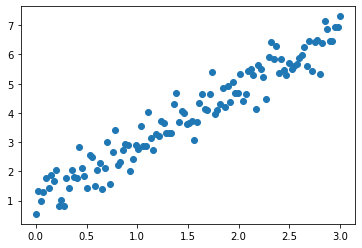

In [14]:
np.random.seed(13) # pick the seed for reproducibility - change it to explore the effects of random variations

train_x = np.linspace(0, 3, 120)
train_labels = 2 * train_x + 0.9 + np.random.randn(*train_x.shape) * 0.5

plt.scatter(train_x,train_labels)

Linear regression is defined by a straight line $f_{W,b}(x) = Wx+b$, where $W, b$ are model parameters that we need to find. An error on our dataset $\{x_i,y_u\}_{i=1}^N$ (also called **loss function**) can be defined as mean square error:
$$
\mathcal{L}(W,b) = {1\over N}\sum_{i=1}^N (f_{W,b}(x_i)-y_i)^2
$$

Let's define our model and loss function:

In [15]:
input_dim = 1
output_dim = 1
learning_rate = 0.1

# This is our weight matrix
w = torch.tensor([100.0],requires_grad=True,dtype=torch.float32)
# This is our bias vector
b = torch.zeros(size=(output_dim,),requires_grad=True)

def f(x):
  return torch.matmul(x,w) + b

def compute_loss(labels, predictions):
  return torch.mean(torch.square(labels - predictions))

We will train the model on a series of minibatches. We will use gradient descent, adjusting model parameters using the following formulae:
$$
\begin{array}{l}
W^{(n+1)}=W^{(n)}-\eta\frac{\partial\mathcal{L}}{\partial W} \\
b^{(n+1)}=b^{(n)}-\eta\frac{\partial\mathcal{L}}{\partial b} \\
\end{array}
$$

In [16]:
def train_on_batch(x, y):
  predictions = f(x)
  loss = compute_loss(y, predictions)
  loss.backward()
  w.data.sub_(learning_rate * w.grad)
  b.data.sub_(learning_rate * b.grad)
  w.grad.zero_()
  b.grad.zero_()
  return loss

Let's do the training. We will do several passes through the dataset (so-called **epochs**), divide it into minibatches and call the function defined above:

In [17]:
# Shuffle the data.
indices = np.random.permutation(len(train_x))
features = torch.tensor(train_x[indices],dtype=torch.float32)
labels = torch.tensor(train_labels[indices],dtype=torch.float32)

In [18]:
batch_size = 4
for epoch in range(10):
  for i in range(0,len(features),batch_size):
    loss = train_on_batch(features[i:i+batch_size].view(-1,1),labels[i:i+batch_size])
  print('Epoch %d: last batch loss = %.4f' % (epoch, float(loss)))

Epoch 0: last batch loss = 94.5247
Epoch 1: last batch loss = 9.3428
Epoch 2: last batch loss = 1.4166
Epoch 3: last batch loss = 0.5224
Epoch 4: last batch loss = 0.3807
Epoch 5: last batch loss = 0.3495
Epoch 6: last batch loss = 0.3413
Epoch 7: last batch loss = 0.3390
Epoch 8: last batch loss = 0.3384
Epoch 9: last batch loss = 0.3382


We now have obtained optimized parameters $W$ and $b$. Note that their values are similar to the original values used when generating the dataset ($W=2, b=1$)

In [19]:
w,b

(tensor([1.8617], requires_grad=True), tensor([1.0711], requires_grad=True))

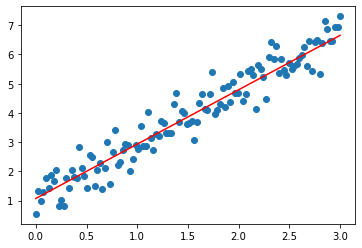

In [20]:
plt.scatter(train_x,train_labels)
x = np.array([min(train_x),max(train_x)])
with torch.no_grad():
  y = w.numpy()*x+b.numpy()
plt.plot(x,y,color='red')

## Computations on GPU

To use GPU for computations, PyTorch supports moving tensors to GPU and building computational graph for GPU. Traditionally, in the beginning of our code we define available computation device `device` (which is either `cpu` or `cuda`), and then move all tensors to this device using a call `.to(device)`. We can also create tensors on the specified device upfront, by passing the parameter `device=...` to tensor creation code. Such code works without changes both on CPU and GPU: 

In [21]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

print('Doing computations on '+device)

### Changes here: indicate device
w = torch.tensor([100.0],requires_grad=True,dtype=torch.float32,device=device)
b = torch.zeros(size=(output_dim,),requires_grad=True,device=device)

def f(x):
  return torch.matmul(x,w) + b

def compute_loss(labels, predictions):
  return torch.mean(torch.square(labels - predictions))

def train_on_batch(x, y):
  predictions = f(x)
  loss = compute_loss(y, predictions)
  loss.backward()
  w.data.sub_(learning_rate * w.grad)
  b.data.sub_(learning_rate * b.grad)
  w.grad.zero_()
  b.grad.zero_()
  return loss

batch_size = 4
for epoch in range(10):
  for i in range(0,len(features),batch_size):
    ### Changes here: move data to required device
    loss = train_on_batch(features[i:i+batch_size].view(-1,1).to(device),labels[i:i+batch_size].to(device))
  print('Epoch %d: last batch loss = %.4f' % (epoch, float(loss)))

Doing computations on cpu
Epoch 0: last batch loss = 94.5247
Epoch 1: last batch loss = 9.3428
Epoch 2: last batch loss = 1.4166
Epoch 3: last batch loss = 0.5224
Epoch 4: last batch loss = 0.3807
Epoch 5: last batch loss = 0.3495
Epoch 6: last batch loss = 0.3413
Epoch 7: last batch loss = 0.3390
Epoch 8: last batch loss = 0.3384
Epoch 9: last batch loss = 0.3382


## Example 2: Classification

Now we will consider binary classification problem. A good example of such a problem would be a tumour classification between malignant and benign based on it's size and age.

The core model is similar to regression, but we need to use different loss function. Let's start by generating sample data:


In [23]:
np.random.seed(0) # pick the seed for reproducibility - change it to explore the effects of random variations

n = 100
X, Y = make_classification(n_samples = n, n_features=2,
                           n_redundant=0, n_informative=2, flip_y=0.1,class_sep=1.5)
X = X.astype(np.float32)
Y = Y.astype(np.int32)

split = [ 70*n//100, (15+70)*n//100 ]
train_x, valid_x, test_x = np.split(X, split)
train_labels, valid_labels, test_labels = np.split(Y, split)

In [24]:
def plot_dataset(features, labels, W=None, b=None):
    # prepare the plot
    fig, ax = plt.subplots(1, 1)
    ax.set_xlabel('$x_i[0]$ -- (feature 1)')
    ax.set_ylabel('$x_i[1]$ -- (feature 2)')
    colors = ['r' if l else 'b' for l in labels]
    ax.scatter(features[:, 0], features[:, 1], marker='o', c=colors, s=100, alpha = 0.5)
    if W is not None:
        min_x = min(features[:,0])
        max_x = max(features[:,1])
        min_y = min(features[:,1])*(1-.1)
        max_y = max(features[:,1])*(1+.1)
        cx = np.array([min_x,max_x],dtype=np.float32)
        cy = (0.5-W[0]*cx-b)/W[1]
        ax.plot(cx,cy,'g')
        ax.set_ylim(min_y,max_y)
    fig.show()

C:\Users\dmitryso\AppData\Local\Temp/ipykernel_89704/2721537645.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


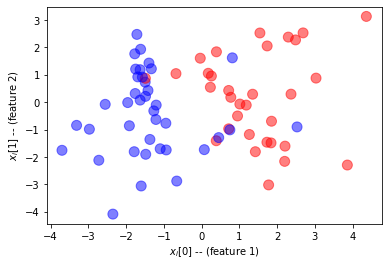

In [25]:
plot_dataset(train_x, train_labels)

## Training One-Layer Perceptron

Let's use PyTorch gradient computing machinery to train one-layer perceptron.

Our neural network will have 2 inputs and 1 output. The weight matrix $W$ will have size $2\times1$, and bias vector $b$ -- $1$.

To make our code more structured, let's group all parameters into a single class:

In [26]:
class Network():
  def __init__(self):
     self.W = torch.randn(size=(2,1),requires_grad=True)
     self.b = torch.zeros(size=(1,),requires_grad=True)

  def forward(self,x):
    return torch.matmul(x,self.W)+self.b

  def zero_grad(self):
    self.W.data.zero_()
    self.b.data.zero_()

  def update(self,lr=0.1):
    self.W.data.sub_(lr*self.W.grad)
    self.b.data.sub_(lr*self.b)

net = Network()

> Note that we use `W.data.zero_()` instead of `W.zero_()`. We need to do this, because we cannot directly modify a tensor that is being tracked using *Autograd* mechanism.

Core model will be the same as in previous example, but loss function will be a logistic loss. To apply logistic loss, we need to get the value of **probability** as the output of our network, i.e. we need to bring the output $z$ to the range [0,1] using `sigmoid` activation function: $p=\sigma(z)$.

If we get the probability $p_i$ for the i-th input value corresponding to the actual class $y_i\in\{0,1\}$, we compute the loss as $\mathcal{L_i}=-(y_i\log p_i + (1-y_i)log(1-p_i))$. 

In PyTorch, both those steps (applying sigmoid and then logistic loss) can be done using one call to `binary_cross_entropy_with_logits` function. Since we are training our network in minibatches, we need to average out the loss across all elements of a minibatch - and that is also done automatically by `binary_cross_entropy_with_logits` function: 

> The call to `binary_crossentropy_with_logits` is equivalent to a call to `sigmoid`, followed by a call to `binary_crossentropy`

In [27]:
def train_on_batch(net, x, y):
  z = net.forward(x).flatten()
  loss = torch.nn.functional.binary_cross_entropy_with_logits(input=z,target=y)
  net.zero_grad()
  loss.backward()
  net.update()
  return loss

To loop through our data, we will use built-in PyTorch mechanism for managing datasets. It is based on two concepts:
* **Dataset** is the main source of data, it can be either **Iterable** or **Map-style**
* **Dataloader** is responsible for loading the data from a dataset and splitting it into minibatches.

In our case, we will define a dataset based on a tensor, and split it into minibatches of 16 elements. Each minibatch contains two tensors, input data (size=16x2) and labels (a vector of length 16 of integer type - class number).

In [28]:
# Create a tf.data.Dataset object for easy batched iteration
dataset = torch.utils.data.TensorDataset(torch.tensor(train_x),torch.tensor(train_labels,dtype=torch.float32))
dataloader = torch.utils.data.DataLoader(dataset,batch_size=16)

list(dataloader)[0]

[tensor([[ 1.5442,  2.5290],
         [-1.6284,  0.0772],
         [-1.7141,  2.4770],
         [-1.4951,  0.7320],
         [-1.6899,  0.9243],
         [-0.9474, -0.7681],
         [ 3.8597, -2.2951],
         [-1.3944,  1.4300],
         [ 4.3627,  3.1333],
         [-1.0973, -1.7011],
         [-2.5532, -0.0777],
         [-1.2661, -0.3167],
         [ 0.3921,  1.8406],
         [ 2.2091, -1.6045],
         [ 1.8383, -1.4861],
         [ 0.7173, -0.9718]]),
 tensor([1., 0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 1., 1.])]

Now we can loop through the whole dataset to train our network for 15 epochs:

In [78]:
for epoch in range(15):
  for (x, y) in dataloader:
    loss = train_on_batch(net,x,y)
  print('Epoch %d: last batch loss = %.4f' % (epoch, float(loss)))

Epoch 0: last batch loss = 0.6491
Epoch 1: last batch loss = 0.6064
Epoch 2: last batch loss = 0.5822
Epoch 3: last batch loss = 0.5679
Epoch 4: last batch loss = 0.5592
Epoch 5: last batch loss = 0.5537
Epoch 6: last batch loss = 0.5501
Epoch 7: last batch loss = 0.5478
Epoch 8: last batch loss = 0.5463
Epoch 9: last batch loss = 0.5454
Epoch 10: last batch loss = 0.5447
Epoch 11: last batch loss = 0.5443
Epoch 12: last batch loss = 0.5441
Epoch 13: last batch loss = 0.5439
Epoch 14: last batch loss = 0.5438


Obtained parameters:

In [29]:
print(net.W,net.b)

tensor([[ 0.1330],
        [-0.2810]], requires_grad=True) tensor([0.], requires_grad=True)


To make sure our training worked, let's plot the line that separates two classes. Separation line is defined by the equation $W\times x + b = 0.5$

C:\Users\dmitryso\AppData\Local\Temp/ipykernel_89704/2721537645.py:17: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


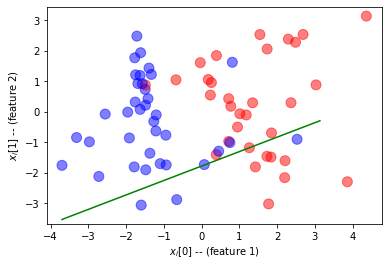

In [30]:
plot_dataset(train_x,train_labels,net.W.detach().numpy(),net.b.detach().numpy())

Not let's compute the accuracy on the validation dataset:

In [31]:
pred = torch.sigmoid(net.forward(torch.tensor(valid_x)))
torch.mean(((pred.view(-1)>0.5)==(torch.tensor(valid_labels)>0.5)).type(torch.float32))

tensor(0.7333)

Let's explain what is going on here:
* `pred` is the vector of predicted probabilities for the whole validation dataset. We compute it by running original validation data `valid_x` through our network, and applying `sigmoid` to get probabilities.
* `pred.view(-1)` creates a flattened view of the original tensor. `view` is similar to `reshape` function in numpy.
* `pred.view(-1)>0.5` returns a boolean tensor or truth value showing the predicted class (False = class 0, True = class 1)
* Similarly, `torch.tensor(valid_labels)>0.5)` creates the boolean tensor of truth values for validation labels
* We compare those two tensors element-wise, and get another boolean tensor, where `True` corresponds to correct prediction, and `False` - to incorrect.
* We convert that tensor to floating point, and take it's mean value using `torch.mean` - that is the desired accuracy 

## Neural Networks and Optimizers

In PyTorch, a special module `torch.nn.Module` is defined to represent a neural network. There are two methods to define your own neural network:
* **Sequential**, where you just specify a list of layers that comprise your network
* As a **class** inherited from `torch.nn.Module`

First method allows you to specify standard networks with sequential composition of layers, while the second one is more flexible, and gives an opportunity to express networks of arbitrary complex architectures. 

Inside modules, you can use standard **layers**, such as:
* `Linear` - dense linear layer, equivalent to one-layered perceptron. It has the same architecture as we have defined above for our network
* `Softmax`, `Sigmoid`, `ReLU` - layers that correspond to activation functions 
* There are also other layers for special network types - convolution, recurrent, etc. We will revisit many of them later in the course.

> Most of the activation function and loss functions in PyTorch are available in two form: as a **function** (inside `torch.nn.functional` namespace) and **as a layer** (inside `torch.nn` namespace). For activation functions, it is often easier to use functional elements from `torch.nn.functional`, without creating separate layer object.

If we want to train one-layer perceptron, we can just use one built-in `Linear` layer:

In [32]:
net = torch.nn.Linear(2,1) # 2 inputs, 1 output

print(list(net.parameters()))

[Parameter containing:
tensor([[-0.0422,  0.1821]], requires_grad=True), Parameter containing:
tensor([0.6582], requires_grad=True)]


As you can see, `parameters()` method returns all the parameters that need to be adjusted during training. They correspond to weight matrix $W$ and bias $b$. You may note that they have `requires_grad` set to `True`, because we need to compute gradients with respect to parameters.

PyTorch also contains built-in **optimizers**, which implement optimization methods such as **gradient descent**. Here is how we can define a **stochastic gradient descent optimizer**:

In [33]:
optim = torch.optim.SGD(net.parameters(),lr=0.05)

Using the optimizer, our training loop will look like this:

In [34]:
val_x = torch.tensor(valid_x)
val_lab = torch.tensor(valid_labels)

for ep in range(10):
  for (x,y) in dataloader:
    z = net(x).flatten()
    loss = torch.nn.functional.binary_cross_entropy_with_logits(z,y)
    optim.zero_grad()
    loss.backward()
    optim.step()
  acc = ((torch.sigmoid(net(val_x).flatten())>0.5).float()==val_lab).float().mean()
  print(f"Epoch {ep}: last batch loss = {loss}, val acc = {acc}")

Epoch 0: last batch loss = 0.7596041560173035, val acc = 0.5333333611488342
Epoch 1: last batch loss = 0.6602361798286438, val acc = 0.6000000238418579
Epoch 2: last batch loss = 0.5847358107566833, val acc = 0.6666666865348816
Epoch 3: last batch loss = 0.5263020992279053, val acc = 0.7333333492279053
Epoch 4: last batch loss = 0.48015740513801575, val acc = 0.800000011920929
Epoch 5: last batch loss = 0.4430023431777954, val acc = 0.8666666746139526
Epoch 6: last batch loss = 0.41254672408103943, val acc = 0.8666666746139526
Epoch 7: last batch loss = 0.3871781527996063, val acc = 0.800000011920929
Epoch 8: last batch loss = 0.3657420873641968, val acc = 0.800000011920929
Epoch 9: last batch loss = 0.34739670157432556, val acc = 0.800000011920929


> You may notice that to apply our network to input data we can use `net(x)` instead of `net.forward(x)`, because `nn.Module` implements Python `__call__()` function

Taking this into account, we can define generic `train` function:

In [35]:
def train(net, dataloader, val_x, val_lab, epochs=10, lr=0.05):
  optim = torch.optim.Adam(net.parameters(),lr=lr)
  for ep in range(epochs):
    for (x,y) in dataloader:
      z = net(x).flatten()
      loss = torch.nn.functional.binary_cross_entropy_with_logits(z,y)
      optim.zero_grad()
      loss.backward()
      optim.step()
    acc = ((torch.sigmoid(net(val_x).flatten())>0.5).float()==val_lab).float().mean()
    print(f"Epoch {ep}: last batch loss = {loss}, val acc = {acc}")

net = torch.nn.Linear(2,1)

train(net,dataloader,val_x,val_lab,lr=0.03)

Epoch 0: last batch loss = 0.48486900329589844, val acc = 0.7333333492279053
Epoch 1: last batch loss = 0.41338109970092773, val acc = 0.800000011920929
Epoch 2: last batch loss = 0.35756850242614746, val acc = 0.800000011920929
Epoch 3: last batch loss = 0.31495171785354614, val acc = 0.800000011920929
Epoch 4: last batch loss = 0.2824164032936096, val acc = 0.800000011920929
Epoch 5: last batch loss = 0.2572754919528961, val acc = 0.800000011920929
Epoch 6: last batch loss = 0.23751722276210785, val acc = 0.800000011920929
Epoch 7: last batch loss = 0.2217157930135727, val acc = 0.800000011920929
Epoch 8: last batch loss = 0.2088666558265686, val acc = 0.800000011920929
Epoch 9: last batch loss = 0.19824868440628052, val acc = 0.800000011920929


## Defining Network as a Sequence of Layers

Now let's train multi-layered perceptron. It can be defined just by specifying a sequence of layers. The resulting object will automatically inherit from `Module`, e.g. it will also have `parameters` method that will return all parameters of the whole network.

In [36]:
net = torch.nn.Sequential(torch.nn.Linear(2,5),torch.nn.Sigmoid(),torch.nn.Linear(5,1))
print(net)

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Sigmoid()
  (2): Linear(in_features=5, out_features=1, bias=True)
)


We can train this multi-layered network using the function `train` that we have defined above:

In [37]:
train(net,dataloader,val_x,val_lab)

Epoch 0: last batch loss = 0.5835739970207214, val acc = 0.800000011920929
Epoch 1: last batch loss = 0.4642275869846344, val acc = 0.800000011920929
Epoch 2: last batch loss = 0.35158076882362366, val acc = 0.800000011920929
Epoch 3: last batch loss = 0.26132312417030334, val acc = 0.800000011920929
Epoch 4: last batch loss = 0.19465585052967072, val acc = 0.800000011920929
Epoch 5: last batch loss = 0.14735405147075653, val acc = 0.800000011920929
Epoch 6: last batch loss = 0.11454981565475464, val acc = 0.800000011920929
Epoch 7: last batch loss = 0.09244414418935776, val acc = 0.800000011920929
Epoch 8: last batch loss = 0.07805468142032623, val acc = 0.800000011920929
Epoch 9: last batch loss = 0.06894762068986893, val acc = 0.800000011920929


## Defining a Network as a Class

Using a class inherited from `torch.nn.Module` is a more flexible method, because we can define any computations inside it. `Module` automates a lot of things, eg. it automatically understands all internal variables that are PyTorch layers, and gathers their parameters for optimization. You just need to define all layers of the network as members of the class:

In [38]:
class MyNet(torch.nn.Module):
  def __init__(self,hidden_size=10,func=torch.nn.Sigmoid()):
    super().__init__()
    self.fc1 = torch.nn.Linear(2,hidden_size)
    self.func = func
    self.fc2 = torch.nn.Linear(hidden_size,1)

  def forward(self,x):
    x = self.fc1(x)
    x = self.func(x)
    x = self.fc2(x)
    return x
  
net = MyNet(func=torch.nn.ReLU())
print(net)

MyNet(
  (fc1): Linear(in_features=2, out_features=10, bias=True)
  (func): ReLU()
  (fc2): Linear(in_features=10, out_features=1, bias=True)
)


In [39]:
train(net,dataloader,val_x,val_lab,lr=0.005)

Epoch 0: last batch loss = 0.7821246981620789, val acc = 0.46666666865348816
Epoch 1: last batch loss = 0.7457502484321594, val acc = 0.5333333611488342
Epoch 2: last batch loss = 0.7120334506034851, val acc = 0.5333333611488342
Epoch 3: last batch loss = 0.6811249256134033, val acc = 0.6666666865348816
Epoch 4: last batch loss = 0.6533011794090271, val acc = 0.7333333492279053
Epoch 5: last batch loss = 0.627849280834198, val acc = 0.7333333492279053
Epoch 6: last batch loss = 0.6030643582344055, val acc = 0.800000011920929
Epoch 7: last batch loss = 0.5775002837181091, val acc = 0.800000011920929
Epoch 8: last batch loss = 0.5522137880325317, val acc = 0.8666666746139526
Epoch 9: last batch loss = 0.5250465869903564, val acc = 0.8666666746139526


**Task 1**: Plot the graphs of loss function and accuracy on training and validation data during training

**Task 2**: Try to solve MNIST classificiation problem using this code. Hint: use `crossentropy_with_logits` as a loss function.

## Takeaways

* PyTorch allows you to operate on tensors at low level, you have most flexibility.
* There are convenient tools to work with data, such as Datasets and Dataloaders.
* You can define neural network architectures using `Sequential` syntax, or inheriting a class from `torch.nn.Module`
* For even simpler approach to defining and training a network - look into PyTorch Lightning